In [29]:
#pip install monai-generative

In [30]:
from monai.networks.nets import UNet

In [31]:
import os
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
from monai.networks.nets import UNet
from generative.networks.nets import PatchDiscriminator

import torch.optim as optim

import matplotlib.pyplot as plt

In [32]:
assert torch.cuda.is_available(), "CUDA not available"
device = torch.device("cuda:0")

In [33]:
class MRISliceDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir

        self.slice_names = sorted([
            f for f in os.listdir(input_dir) if f.endswith(".pt")
        ])

    def __len__(self):
        return len(self.slice_names)
    
    def normalize(self, img):
         #TODO: better way to do normalization? MONAI ScaleIntensityRanged
        img = (img - img.min()) / (img.max() - img.min())
        return img

    def __getitem__(self, idx):
        name = self.slice_names[idx]
        input_tensor = torch.load(os.path.join(self.input_dir, name), weights_only=True) 
        target_tensor = torch.load(os.path.join(self.target_dir, name),weights_only=True) 
        input_tensor = self.normalize(input_tensor)
        target_tensor = self.normalize(target_tensor)

        return input_tensor, target_tensor


In [34]:
class AdditiveUpsample2d(nn.Module):

    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        assert in_ch % 4 == 0, "in_ch must be divisible by 4."
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        # optional refinement conv
        self.refine = nn.Conv2d(in_ch // 4, out_ch, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.up(x)                  
        B, C, H, W = x.shape
        x = x.view(B, C // 4, 4, H, W).sum(2)  
        return self.refine(x)

In [35]:
class AdditiveUNet(UNet):
    def _get_up_layer(self, in_channels, out_channels, strides, is_top):
        return AdditiveUpsample2d(in_channels, out_channels)


In [36]:
# Paths 
train_input = "../slices/train/target"
train_target = "../slices/train/target"  
test_input = "../slices/test/target"
test_target = "../slices/test/target"   

# Dataset
train_dataset = MRISliceDataset(train_input, train_target)
test_dataset = MRISliceDataset(test_input, test_target)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [37]:
def preview_data(loader, overall_index):
    batch_size = loader.batch_size
    batch_idx = overall_index // batch_size
    index_in_batch = overall_index % batch_size

    for i, (inputs, targets) in enumerate(loader):
        if i == batch_idx:
            if index_in_batch >= len(inputs):
                print(f"Index {index_in_batch} is out of range for batch {i}")
                return

            input_img = inputs[index_in_batch, 0].cpu().numpy()
            target_img = targets[index_in_batch, 0].cpu().numpy()

            plt.figure(figsize=(8, 3))
            plt.subplot(1, 2, 1)
            plt.imshow(input_img, cmap='gray')
            plt.title(f'Input (Index {overall_index})')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(target_img, cmap='gray')
            plt.title("Target")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            return


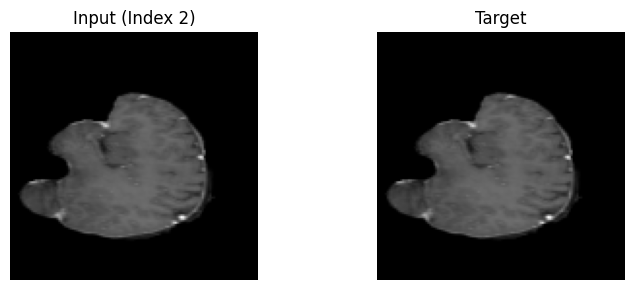

In [38]:
preview_data(train_loader, 2)

In [39]:
USE_SIGMOID= False
#SHOW_TRAINING_PROGRESS = 

In [44]:

generator = UNet(
    spatial_dims=2,   #2d
    in_channels=1,    # t1c
    out_channels=1,   #target
    channels=(64, 128, 256, 512),
    strides=(2, 2, 2),
    num_res_units=2
)

if USE_SIGMOID:   
    generator = nn.Sequential(
        generator,
        nn.Sigmoid()
    )


discriminator = PatchDiscriminator(
    spatial_dims=2,
    in_channels=2,
    num_channels=64,
    kernel_size=4
)

generator = generator.to(device)
discriminator = discriminator.to(device)

#Loss
#TODO: change with sigmoid layer?
adversarial_loss = nn.BCEWithLogitsLoss() 
l1_loss = nn.L1Loss()

#Optimization
lr = 2e-4  

#TODO: need to understand beta parameters
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999)) 
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [45]:

num_epochs = 80
lambda_l1 = 10  # weight for L1 loss

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)     
        targets = targets.to(device)  

        # train discriminator
        d_optimizer.zero_grad()

        # Real 
        real_pair = torch.cat([inputs, targets], dim=1) 
        real_pred = discriminator(real_pair)[-1]
        real_label = torch.ones_like(real_pred, device=device)
        loss_d_real = adversarial_loss(real_pred, real_label)

        # Fake 
        fake = generator(inputs).detach()
        fake_pair = torch.cat([inputs, fake], dim=1)
        fake_pred = discriminator(fake_pair)[-1]
        fake_label = torch.zeros_like(fake_pred)
        loss_d_fake = adversarial_loss(fake_pred, fake_label)

        
        #TODO: make function print stats +visualizations
        
        #if SHOW_TRAINING_PROGRESS: 
        '''
        if epoch % 5 == 0 and i == 0:
            
            print("Fake output stats:")
            print("  min:", fake.min().item())
            print("  max:", fake.max().item())
            print("  mean:", fake.mean().item())
            
            print("Target (real post-op) stats:")
            print("  min:", targets.min().item())
            print("  max:", targets.max().item())
            print("  mean:", targets.mean().item())
        '''
         
        
            

        # d loss total
        loss_d = (loss_d_real + loss_d_fake) * 0.5
        loss_d.backward()
        d_optimizer.step()

        ## generator
        g_optimizer.zero_grad()

        fake = generator(inputs)
        fake_pair = torch.cat([inputs, fake], dim=1)
        pred_fake = discriminator(fake_pair)[-1]
        

        loss_g_adv = adversarial_loss(pred_fake, real_label)
        

        loss_g_l1 = l1_loss(fake, targets) * lambda_l1
        loss_g = loss_g_adv + loss_g_l1
        #loss_g = l1_loss(fake, targets) * lambda_l1

        loss_g.backward()
        g_optimizer.step()

        # print
        
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}]  "
                  f"D Loss: {loss_d.item():.4f}  G Loss: {loss_g.item():.4f}")
        
            


Epoch [1/80] Step [0]  D Loss: 0.8463  G Loss: 5.8332
Epoch [2/80] Step [0]  D Loss: 0.2373  G Loss: 4.1290
Epoch [3/80] Step [0]  D Loss: 0.3286  G Loss: 4.0285
Epoch [4/80] Step [0]  D Loss: 0.1475  G Loss: 4.8362
Epoch [5/80] Step [0]  D Loss: 0.1924  G Loss: 5.1056
Epoch [6/80] Step [0]  D Loss: 0.0545  G Loss: 5.0373
Epoch [7/80] Step [0]  D Loss: 0.0323  G Loss: 5.5785
Epoch [8/80] Step [0]  D Loss: 0.0351  G Loss: 5.8813
Epoch [9/80] Step [0]  D Loss: 0.0212  G Loss: 6.4695
Epoch [10/80] Step [0]  D Loss: 0.0177  G Loss: 6.5310
Epoch [11/80] Step [0]  D Loss: 0.0175  G Loss: 6.4201
Epoch [12/80] Step [0]  D Loss: 0.0141  G Loss: 6.4684
Epoch [13/80] Step [0]  D Loss: 0.0114  G Loss: 6.9290
Epoch [14/80] Step [0]  D Loss: 0.0073  G Loss: 7.5375
Epoch [15/80] Step [0]  D Loss: 0.0083  G Loss: 7.0276
Epoch [16/80] Step [0]  D Loss: 0.0073  G Loss: 7.1951
Epoch [17/80] Step [0]  D Loss: 0.0072  G Loss: 6.9398
Epoch [18/80] Step [0]  D Loss: 0.0073  G Loss: 7.0338
Epoch [19/80] Step 

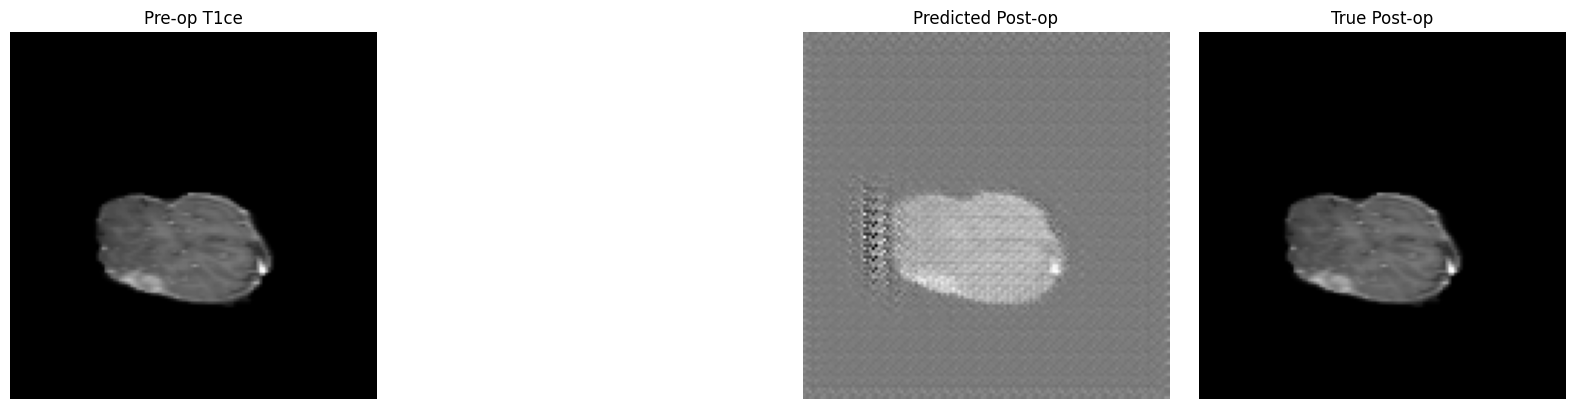

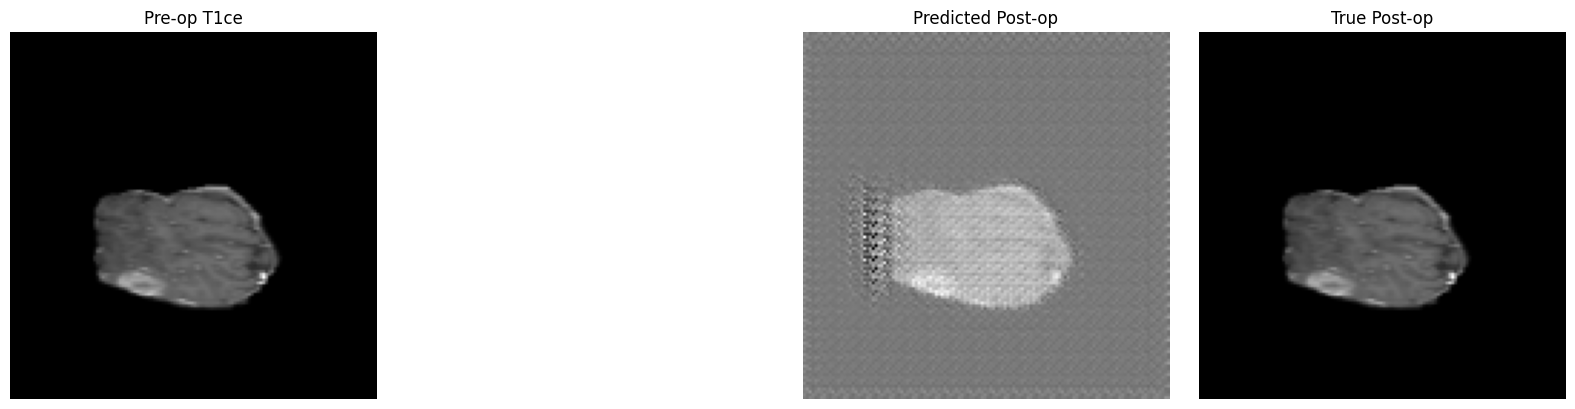

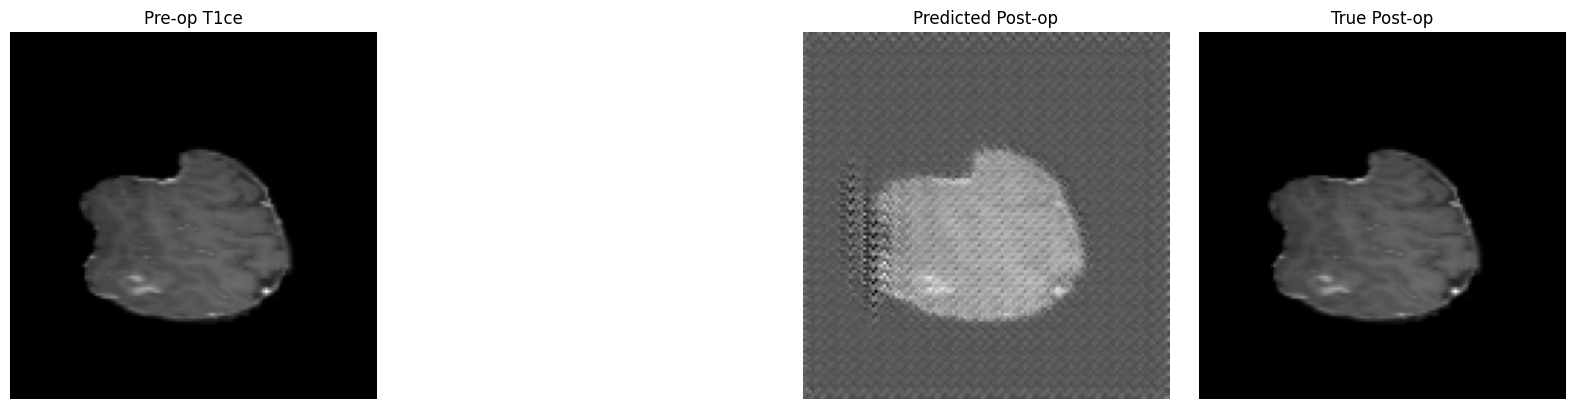

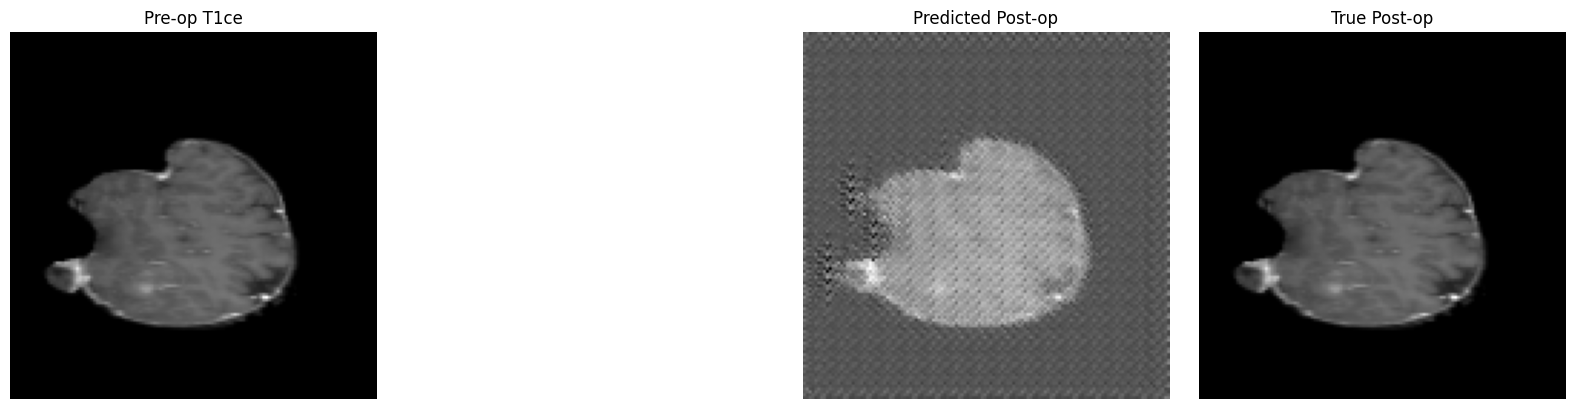

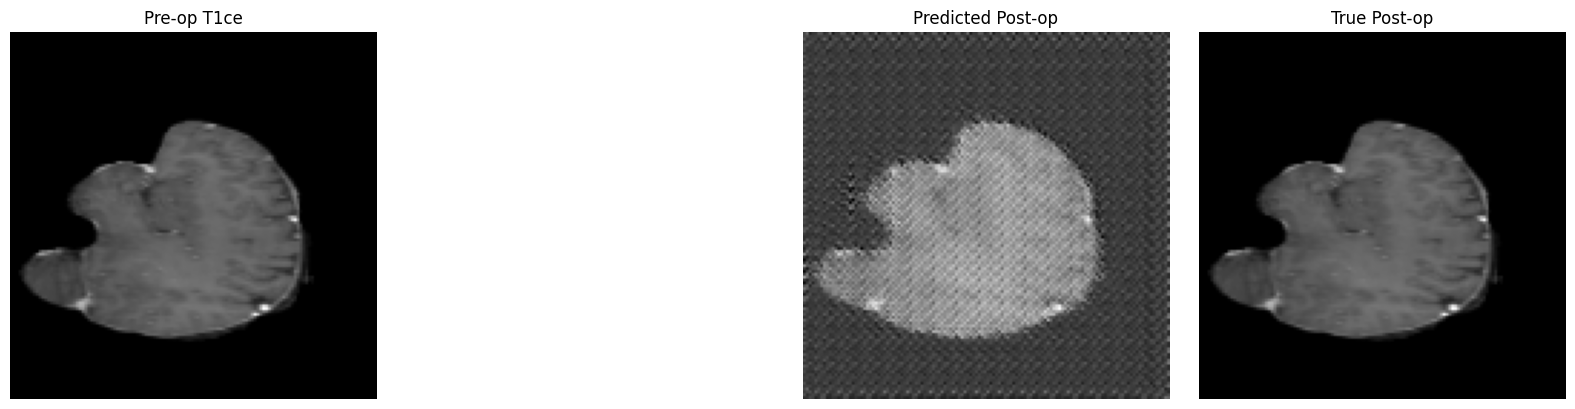

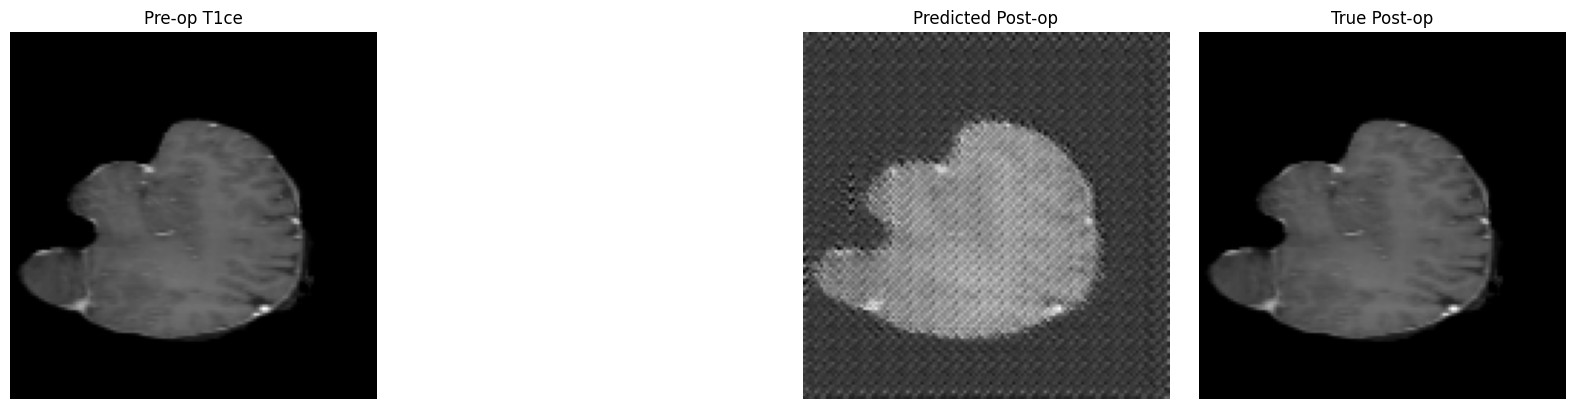

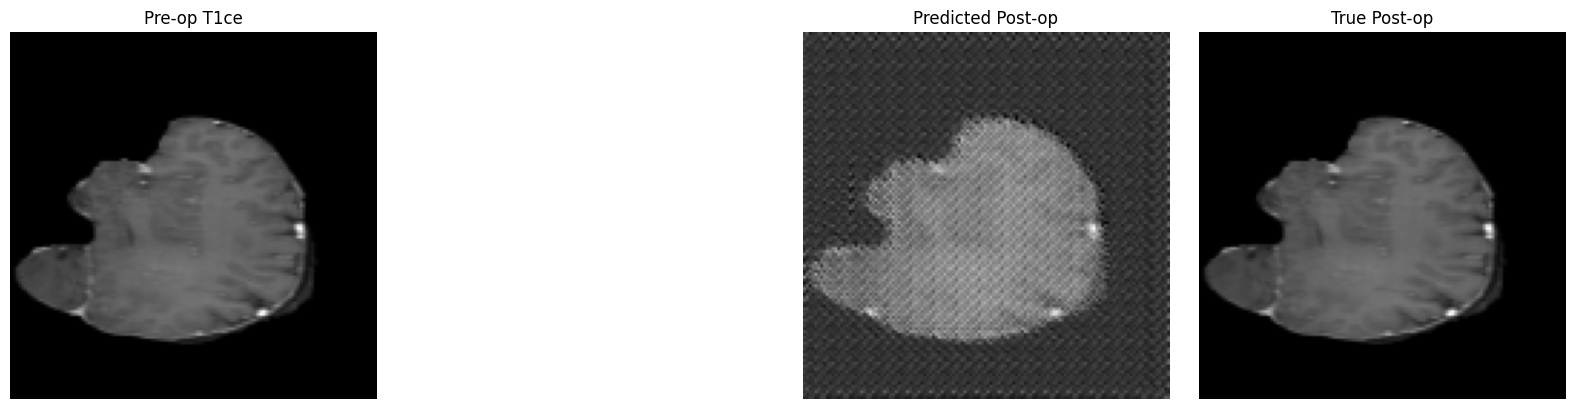

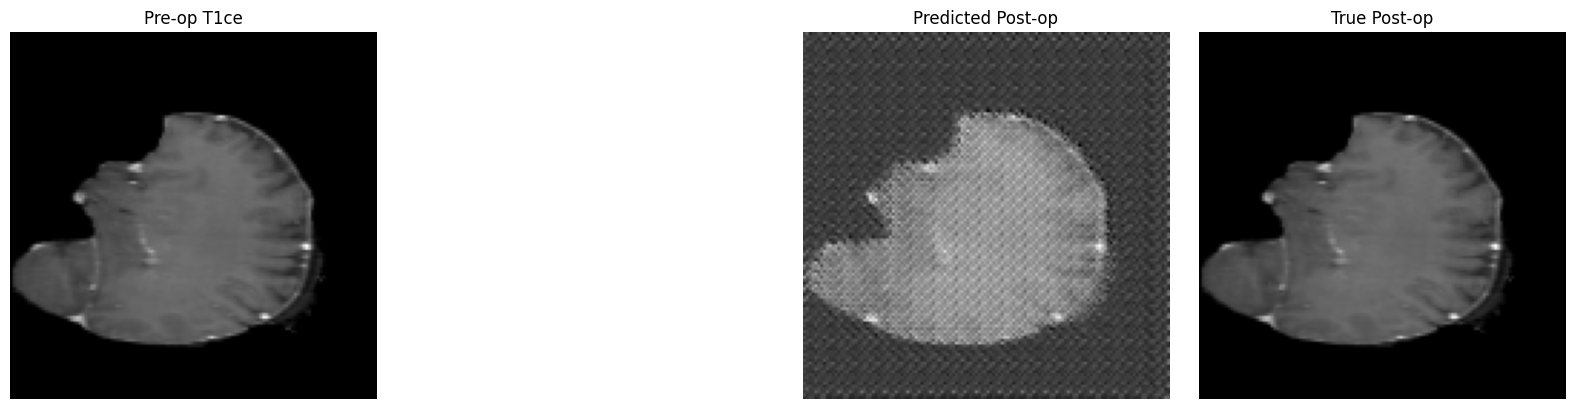

In [46]:
num_samples = 8  

indices = list(range(len(test_dataset)))[:num_samples] 

for idx in indices:
    input_tensor, target_tensor = test_dataset[idx]
    input_tensor = input_tensor.unsqueeze(0).to(device)  

    with torch.no_grad():
        pred_tensor = generator(input_tensor)

    t1ce = input_tensor[0, 0].cpu()
    #seg = input_tensor[0, 1].cpu()
    pred = pred_tensor[0, 0].cpu()
    target = target_tensor[0].cpu()

    # Plot
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(t1ce, cmap='gray')
    axs[0].set_title("Pre-op T1ce")
    #axs[1].imshow(seg, cmap='gray')
    #axs[1].set_title("Segmentation")
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title("Predicted Post-op")
    axs[3].imshow(target, cmap='gray')
    axs[3].set_title("True Post-op")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()
